In [10]:
import visualize_attention
import torch
import models_vit as vits
from PIL import Image
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import glob
import random

In [11]:
arch = 'vit_base_patch16'
global_pool = True
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
decoder = False
pretrained_weights = '/media/gabriel/BA1041B410417881/Users/gabrielc/Projects/mae/output_epochs/ft/base/2000/checkpoint.pth'
images_path = '/home/gabriel/Downloads/selected_castasv6_xai'
image_size = 224
patch_size = 16
threshold = 0.25

model = vits.__dict__[arch](
        num_classes=0,
        drop_path_rate=0,
        global_pool=global_pool,
    )

#model = vits.__dict__[args.arch](patch_size=args.patch_size, num_classes=0)
for p in model.parameters():
    p.requires_grad = False

model.eval()
model.to(device)


if decoder:
    checkpoint = torch.load(pretrained_weights, map_location='cpu')

    print("Load pre-trained DECODER checkpoint from: %s" % pretrained_weights)
    checkpoint_model = checkpoint['model']
    state_dict = model.state_dict()
    for k in ['head.weight', 'head.bias']:
        if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
            print(f"Removing key {k} from pretrained checkpoint")
            del checkpoint_model[k]

    print(model.head)
    
    # interpolate position embedding
    visualize_attention.interpolate_pos_embed(model, checkpoint_model)

    print(model.head)
    # load pre-trained model
    msg = model.load_state_dict(checkpoint_model, strict=False)

    print(msg)
    

    if global_pool:
        assert set(msg.missing_keys) == {'head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias'}
    else:
        assert set(msg.missing_keys) == {'head.weight', 'head.bias'}

    
    # manually initialize fc layer
    visualize_attention.trunc_normal_(model.head.weight, std=2e-5)
    print(model.head)
else:
    state = torch.load(pretrained_weights, map_location='cpu')
    print(state.keys())
    msg = model.load_state_dict(state['model'], strict=False)
    print(msg)
    model.to(device)
    model.eval()

transform = visualize_attention.pth_transforms.Compose([
        visualize_attention.pth_transforms.Resize(image_size),
        visualize_attention.pth_transforms.ToTensor(),
        visualize_attention.pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

dict_keys(['model', 'optimizer', 'epoch', 'scaler', 'args'])
_IncompatibleKeys(missing_keys=[], unexpected_keys=['head.weight', 'head.bias'])


In [16]:
images = ['/home/gabriel/Downloads/selected_castasv6_xai/20230602,iPhone_14,IMG_2151.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230519,iPhone_14,IMG_0970.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230602,iPhone_14,IMG_2320.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230630,Canon_EOS_Rebel_T100,IMG_5625.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230630,iPhone_14,IMG_6043.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230602,iPhone_14,IMG_2151.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230630,iPhone_14,IMG_5979.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20210715,Unknown,IMG_6306.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230602,iPhone_14,IMG_2039.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230630,Canon_EOS_Rebel_T100,IMG_5355.jpg']

(12, 224, 224)
(12, 224, 224)
(12, 224, 224)
(12, 224, 224)
(12, 224, 224)
(12, 224, 224)
(12, 224, 224)
(12, 224, 224)
(12, 224, 224)
(12, 224, 224)


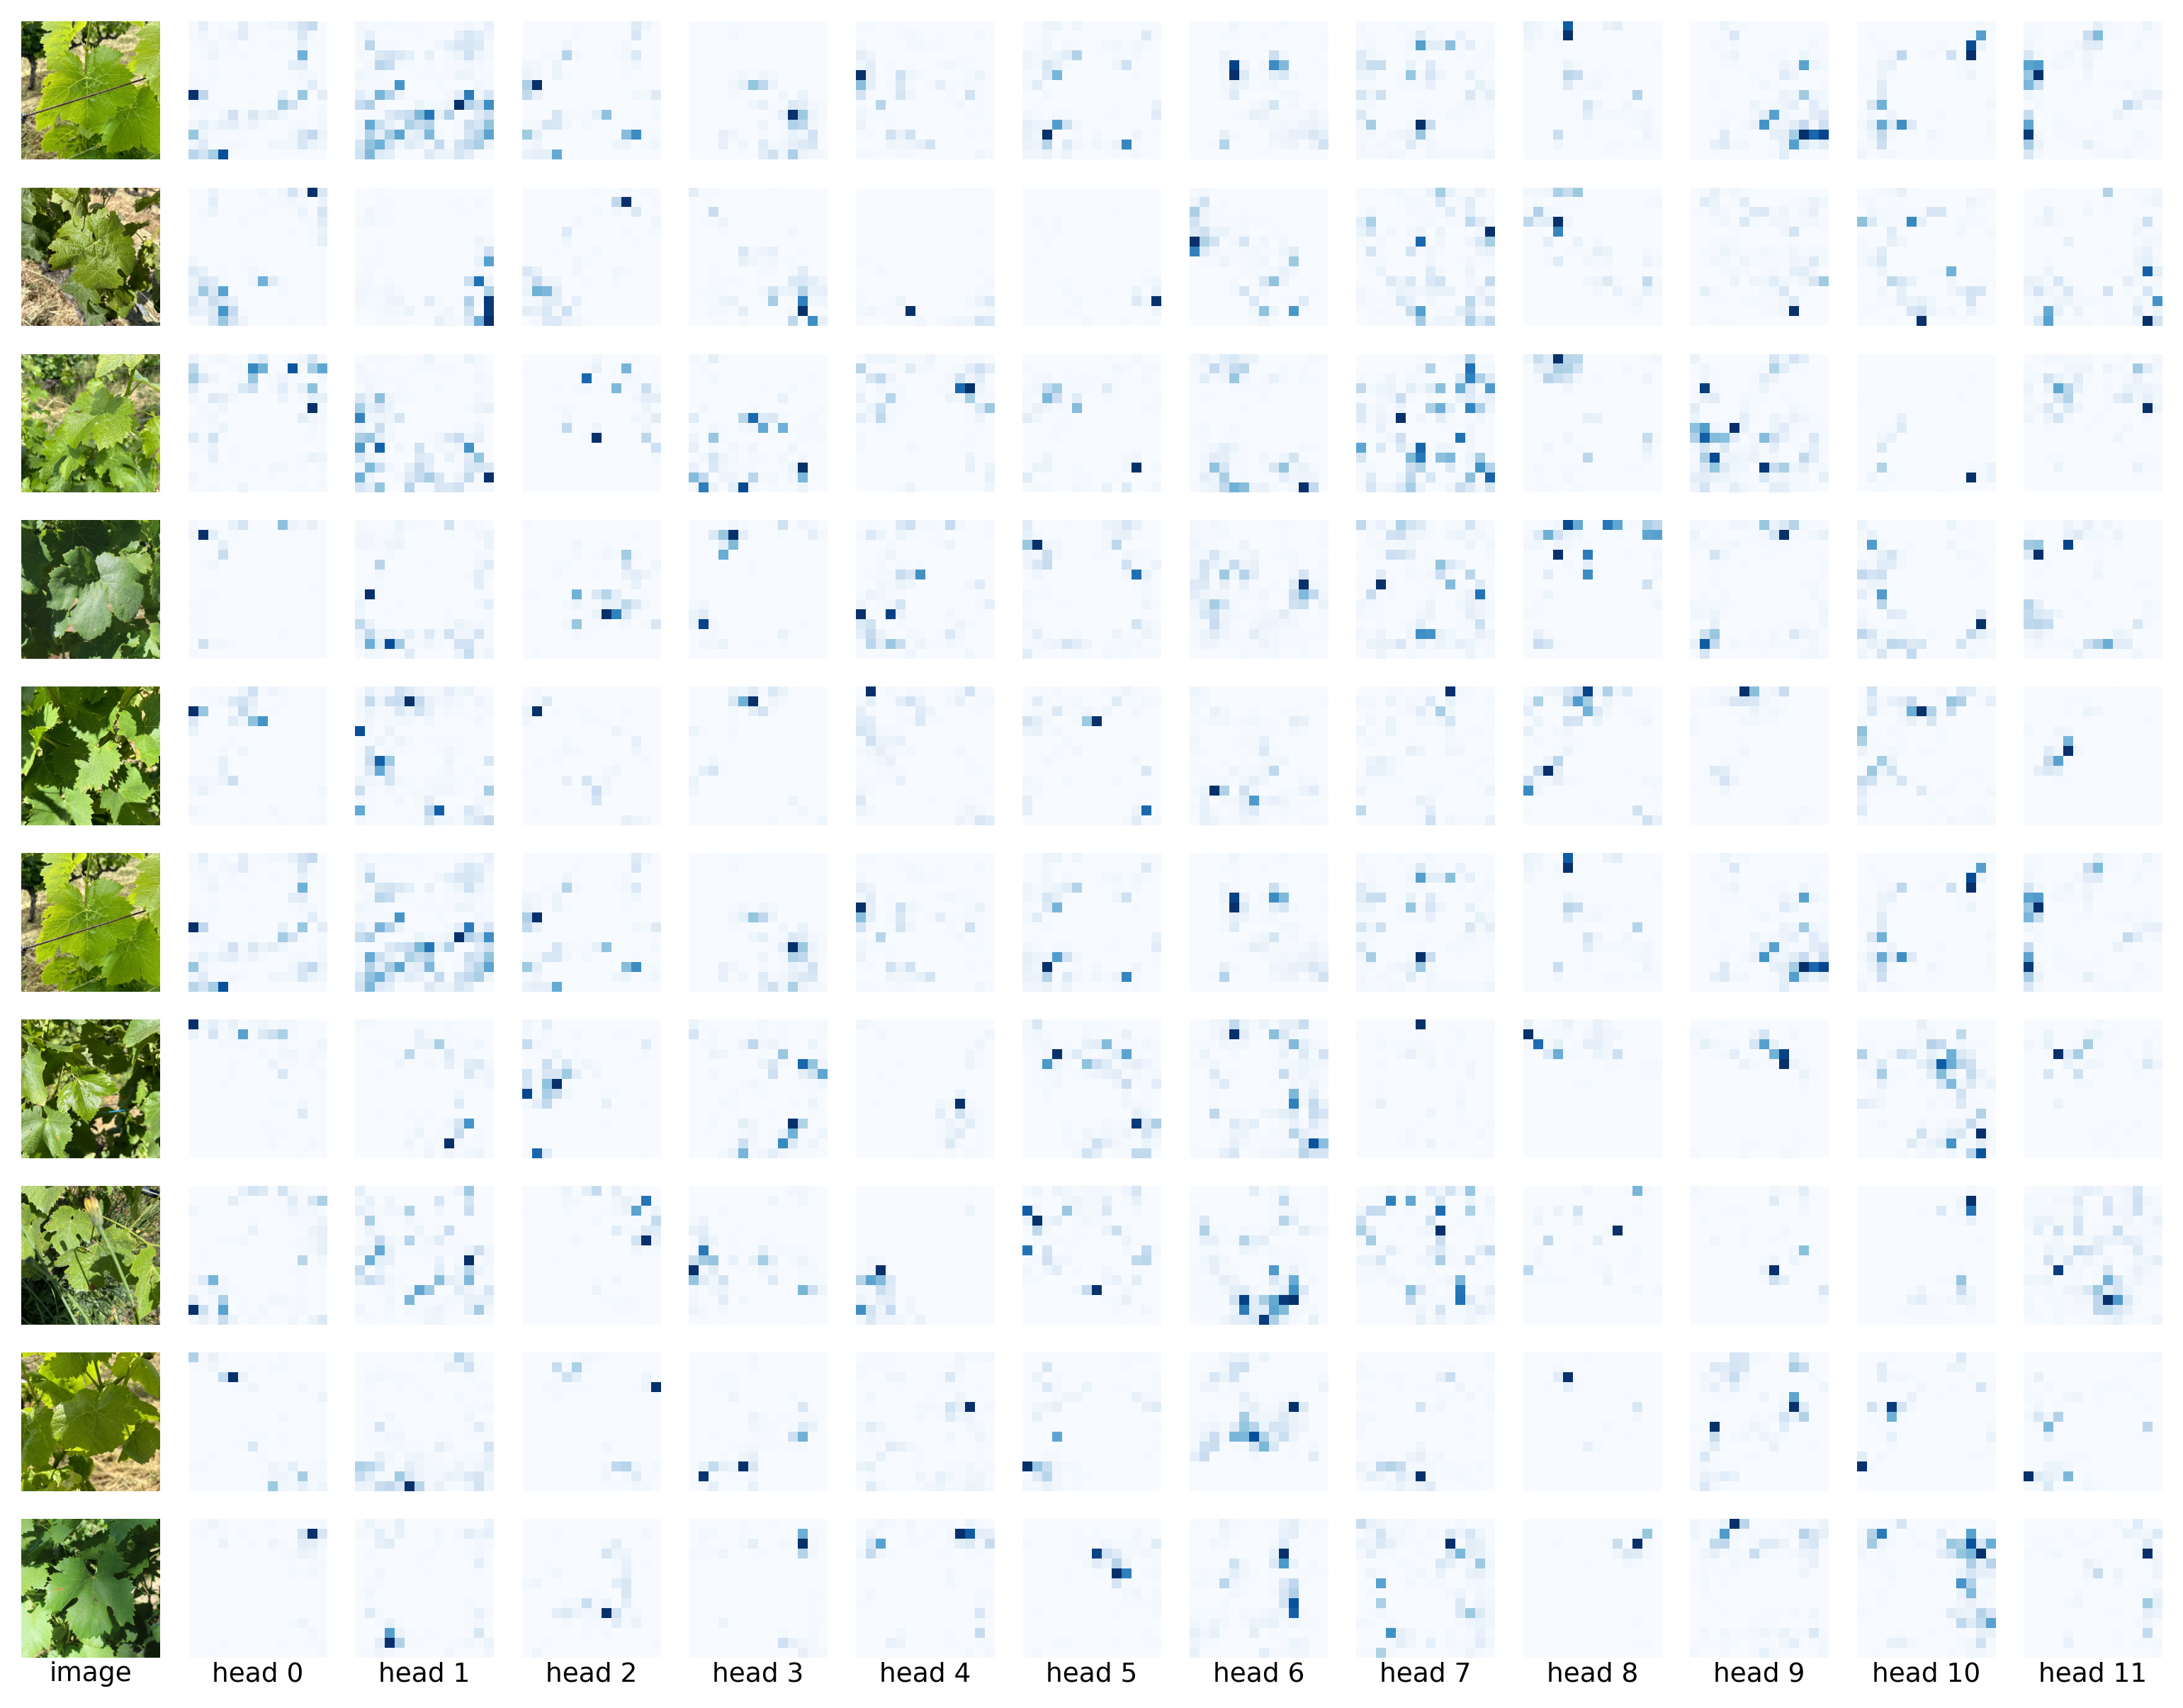

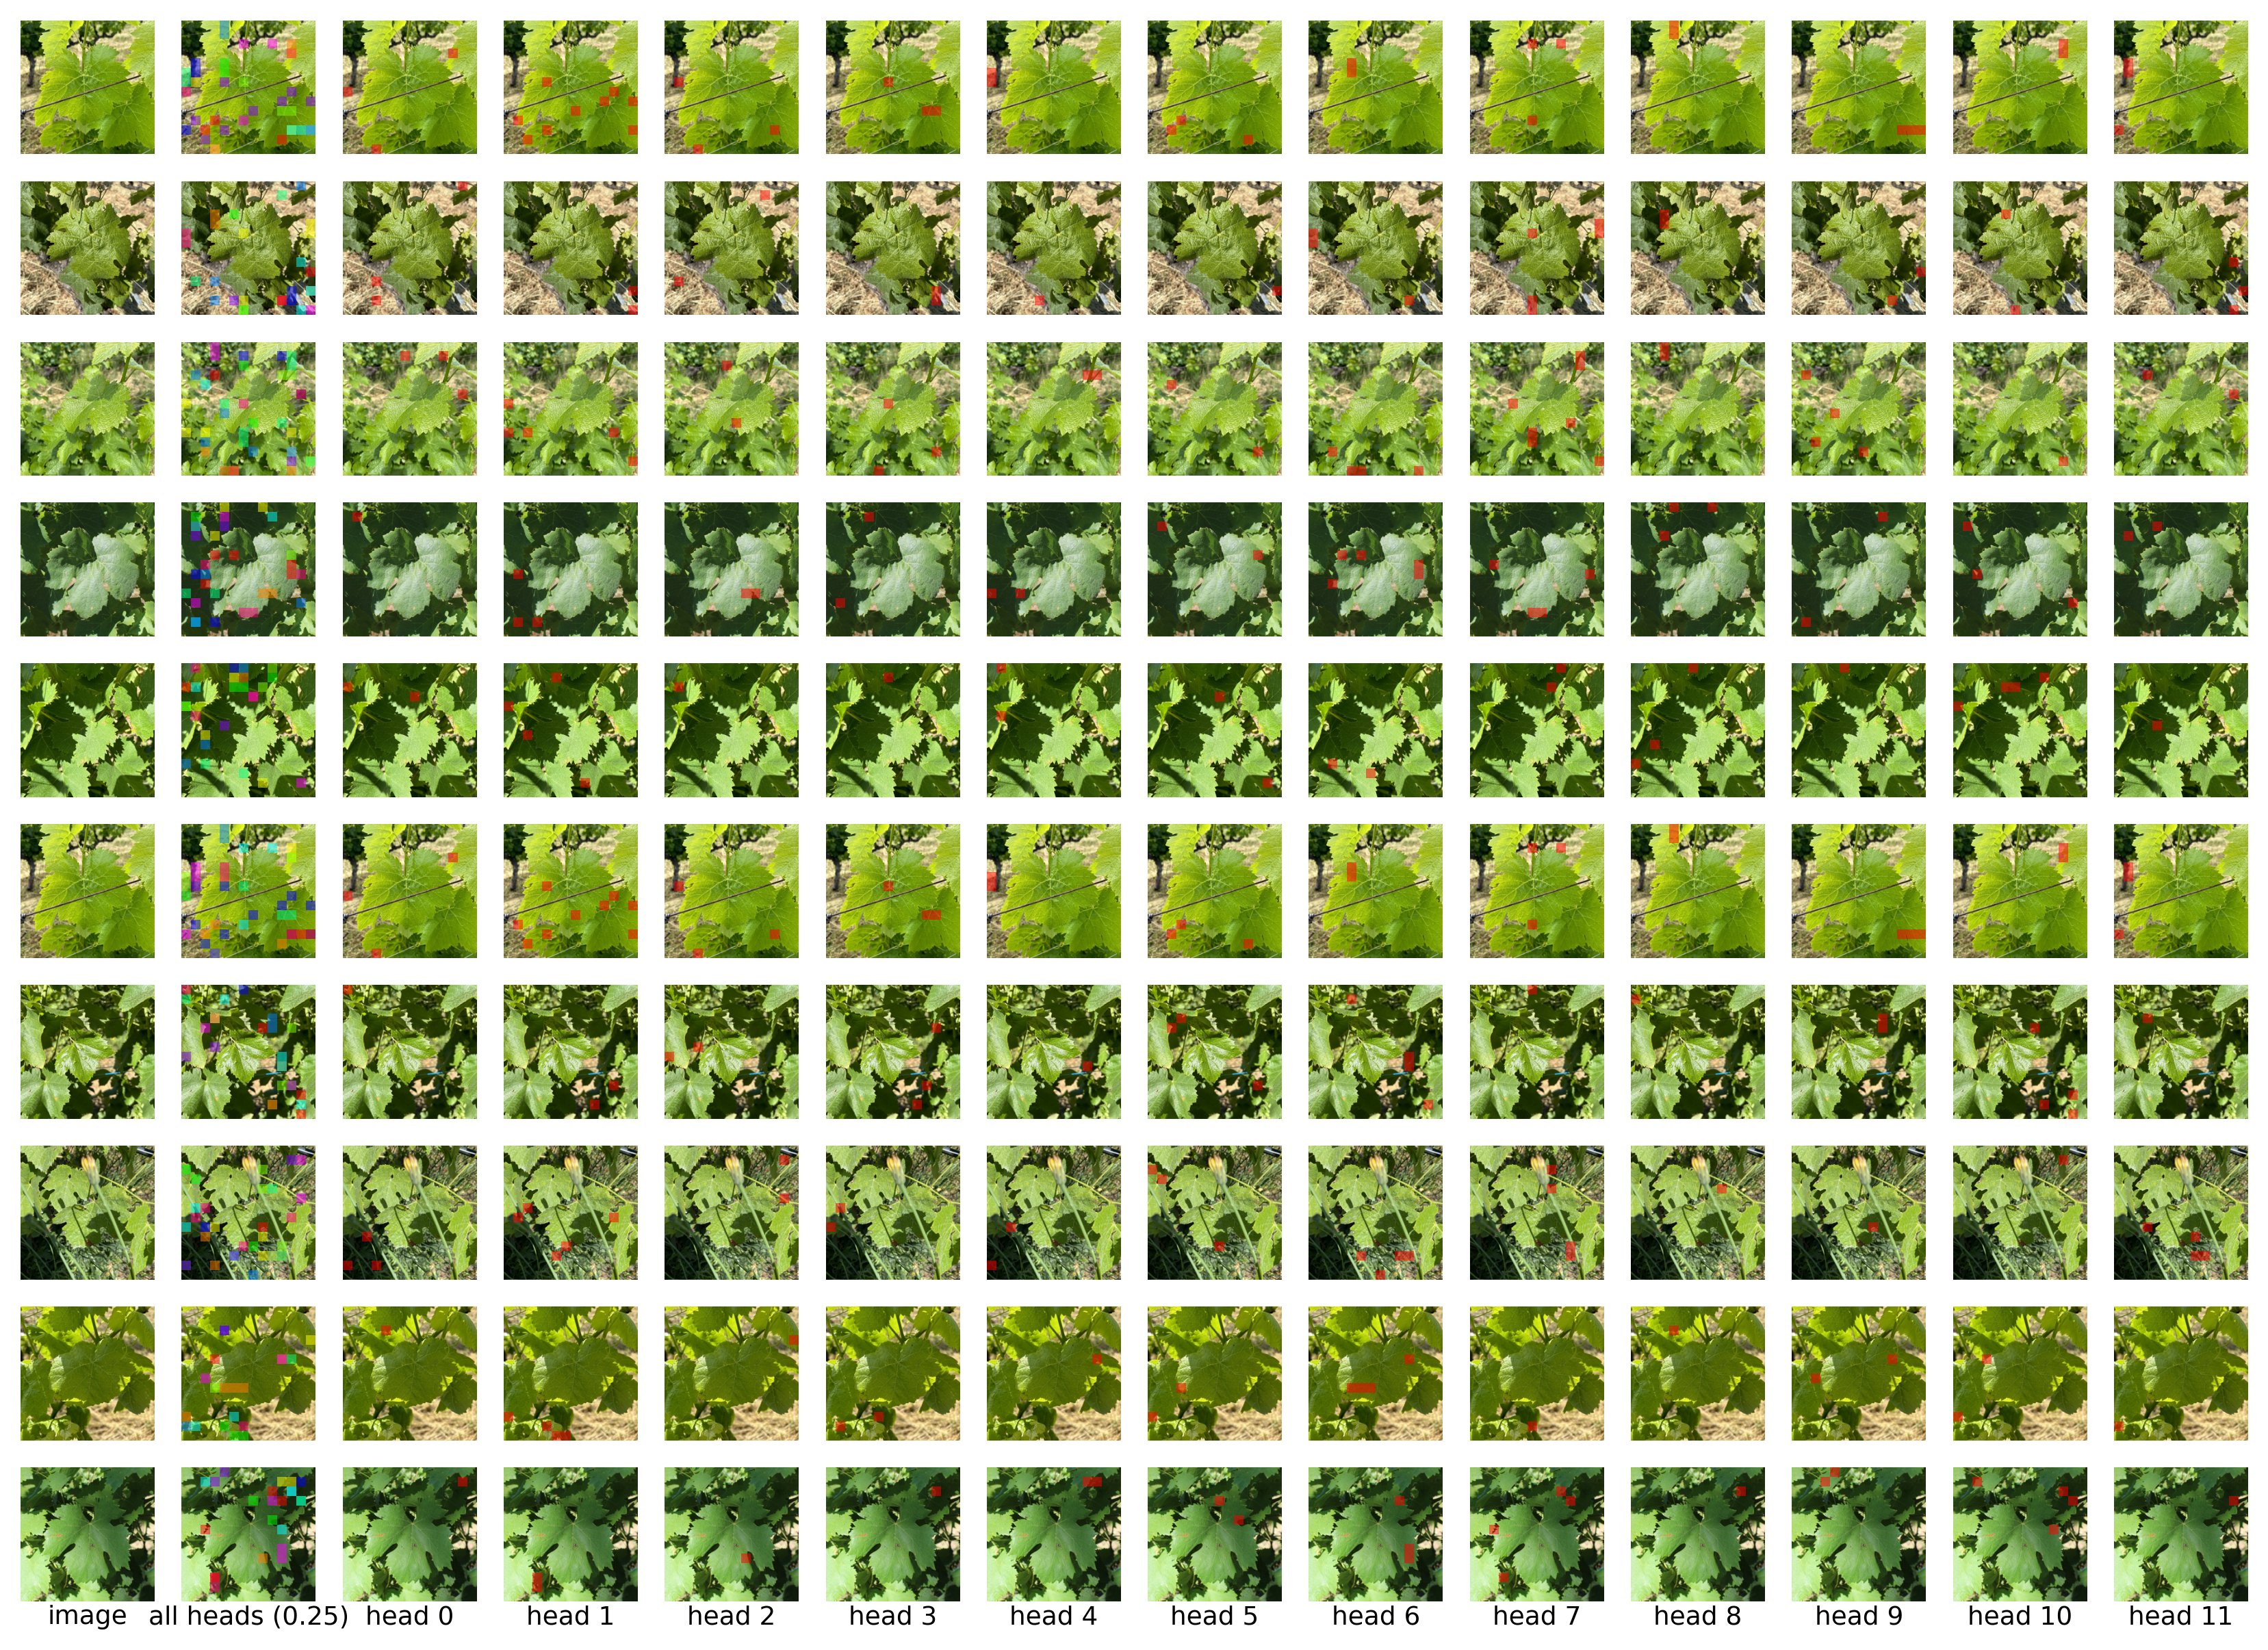

In [14]:
#images = glob.glob(images_path + "/*.jpg")
#images = random.choices(images, k=10)

#create dumb image to get the number of head
image = (np.random.rand(image_size, image_size, 3)*255).astype(np.uint8)
image = transform(Image.fromarray(image)).unsqueeze(0).to(device)
nh = visualize_attention.get_last_selfattention(model, image).shape[1] # number of head 
fig, axs = plt.subplots(len(images), nh+1, figsize=(nh+1, len(images)), dpi=300)
if threshold is not None:
    fig2, axs2 = plt.subplots(len(images), nh+2, figsize=(nh+2, len(images)), dpi=300)



for i, image_path in enumerate(images):
    image = Image.open(image_path).convert("RGB")
    image_bkp = image.copy().resize((image_size, image_size))
    axs[i,0].imshow(image)
    if i == len(images) - 1:
        axs[i, 0].text(0.5,-0.17, f"image", size=9, ha="center", transform=axs[i,0].transAxes)
        
    image = transform(image)
    image = image.to(device)

    w, h = image.shape[1] - image.shape[1] % patch_size, image.shape[2] - image.shape[2] % patch_size
    image = image[:, :w, :h].unsqueeze(0)


    w_featmap = image.shape[-2] // patch_size
    h_featmap = image.shape[-1] // patch_size

    attentions = visualize_attention.get_last_selfattention(model, image.to(device))


    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    if threshold is not None:
        axs2[i,0].imshow(image_bkp)
        if i == len(images) - 1:
            axs2[i, 0].text(0.5,-.17, f"image", size=9, ha="center", transform=axs2[i,0].transAxes)
        # we keep only a certain percentage of the mass
        val, idx = torch.sort(attentions)
        val /= torch.sum(val, dim=1, keepdim=True)
        cumval = torch.cumsum(val, dim=1)
        th_attn = cumval > (1 - threshold)
        idx2 = torch.argsort(idx)
        for head in range(nh):
            th_attn[head] = th_attn[head][idx2[head]]
        th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
        # interpolate
        th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

    for j in range(nh):
        axs[i,j+1].imshow(attentions[j], cmap='Greens')
        if i == len(images) - 1:
            axs[i, j+1].text(0.5,-0.17, f"head {j}", size=9, ha="center", transform=axs[i, j+1].transAxes)
    
    if threshold is not None:
        axs2[i,1].imshow(visualize_attention.display_instances_v2(np.array(image_bkp), th_attn, blur=False, save_fig=False))
        if i == len(images) - 1:
            axs2[i, 1].text(0.5,-0.17, f"all({round(threshold, 2)})", size=9, ha="center", transform=axs2[i,1].transAxes)
        for j in range(nh):
            axs2[i,j+2].imshow(visualize_attention.display_instances(np.array(image_bkp), th_attn[j], blur=False, save_fig=False))
            if i == len(images) - 1:
                axs2[i, j+2].text(0.5,-0.17, f"head {j}", size=9, ha="center", transform=axs2[i, j+2].transAxes)


for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')
    
fig.savefig("attention.jpg")
if threshold is not None:
    for ax_row in axs2:
        for ax in ax_row:
            ax.axis('off')
    fig2.savefig("attention_threshold.jpg")
        


In [15]:
images

['/home/gabriel/Downloads/selected_castasv6_xai/20230602,iPhone_14,IMG_2151.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230519,iPhone_14,IMG_0970.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230602,iPhone_14,IMG_2320.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230630,Canon_EOS_Rebel_T100,IMG_5625.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230630,iPhone_14,IMG_6043.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230602,iPhone_14,IMG_2151.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230630,iPhone_14,IMG_5979.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20210715,Unknown,IMG_6306.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230602,iPhone_14,IMG_2039.jpg',
 '/home/gabriel/Downloads/selected_castasv6_xai/20230630,Canon_EOS_Rebel_T100,IMG_5355.jpg']